### 13 Jan 2023

# Example Fig. 4 code.

In [272]:
# load packages
import pandas as pd
import matplotlib.pyplot as plt
import cmocean

## 2014

### 1. Read seal data

In [273]:
# To read from pickle after already created 
seal14 = pd.read_pickle('seal14_file')

### 2. Prepare data for plotting in TS space and combine all winter months in dataframe
Partitioning by month is not necessary, if not interested in monthly variability

In [274]:
# Bounds within study area (orange dashed box in Fig. 1)
# may 2014
may14TS = seal14[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100')
may14TS = may14TS[(may14TS['Datetime']>='2014-5-1') & (may14TS['Datetime']<'2014-6-1')]  # now constraining dates
may14TS = may14TS.reset_index()

# june 2014
june14TS = seal14[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100')
june14TS = june14TS[(june14TS['Datetime']>='2014-6-1') & (june14TS['Datetime']<'2014-7-1')]  # now constraining dates
june14TS = june14TS.reset_index()

# july 2014
july14TS = seal14[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100')
july14TS = july14TS[(july14TS['Datetime']>='2014-7-1') & (july14TS['Datetime']<'2014-8-1')]  # now constraining dates
july14TS = july14TS.reset_index()

# aug 2014
aug14TS = seal14[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100')
aug14TS = aug14TS[(aug14TS['Datetime']>='2014-8-1') & (aug14TS['Datetime']<'2014-9-1')]  # now constraining dates
aug14TS = aug14TS.reset_index()

TS2014 = pd.concat([may14TS,june14TS,july14TS,aug14TS])

### 3. Calculate mCDW and WW endoints (MW are from literature)

#### A. Winter Water
Winter Water is a freezing point (CT = 1.86 C). To find corresponding SA endpoint: extract maximum SA that lies on freezing line.

In [275]:
# Winter Water

# We are looking for maximum SA that lines on the freezing line (i.e., at CT -1.86)
TS2014_freezingline = TS2014[(TS2014['CT']<-1.85999) & (TS2014['CT']>-1.861)]
TS2014_freezingline.head()

TS2014_freezingline['SA'].max()

34.316692026149155

#### B. mCDW
To find mCDW SA and CT endpoints, do some simple stats to find the maximum and most commonly recurring measurements (mode) in a typical range for CDW (e.g., SA > 34.7, CT > 0.5)

Max: 34.893354221428645 Mode: 34.81601417553008


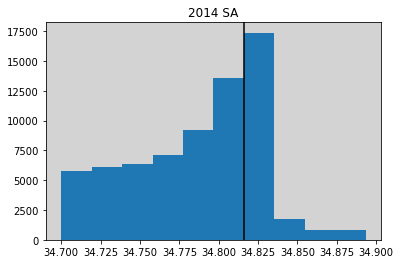

In [276]:
# 2014 SA
# plotting histograms for visualization

SA14_histcdw = TS2014[TS2014['SA']>34.7]

n, bins, _ = plt.hist(SA14_histcdw['SA']) 
mode_index = n.argmax()
mode14sa = bins[mode_index]

print('Max:',SA14_histcdw['SA'].max(),'Mode:',bins[mode_index])
plt.axvline(bins[mode_index], c='k')
plt.title('2014 SA')
plt.show()

Max: 1.1356752222033513 Mode: 1.008541201391619


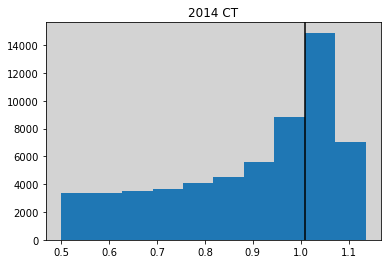

In [277]:
# 2014 CT
CT14_histcdw = TS2014[TS2014['CT']>0.5]

n, bins, _ = plt.hist(CT14_histcdw['CT']) 
mode_index = n.argmax()
mode14ct = bins[mode_index]

print('Max:',CT14_histcdw['CT'].max(),'Mode:',bins[mode_index])
plt.axvline(bins[mode_index], c='k')
plt.title('2014 CT')
plt.show()

Based on these stats and previous papers (Zheng et al., 2021), we keep maximum CT and SA values as end points for mCDW. See manuscript for full explanation.

### 4. Define water mass (mCDW, WW, MW) endpoints (from step 3 calculations)

CT is conservative temperature,
SA is absolute salinity

In [278]:
# water mass endpoints (rounded to 2nd decimal)
ct_MW = -90.8; sa_MW = 0;          # MW = glacial meltwater -- these are from literature
ct_mCDW=1.14; sa_mCDW=34.89;       # CDW = Circumpolar Deep Water 
ct_WW=-1.86; sa_WW=34.32;          # WW = Winter Water

### 5. Calculate meltwater fraction

In [279]:
# remove NaN values
winter14CTSA = may14TS[['CT','SA','z','Datetime','LATITUDE','LONGITUDE','Station']].append([june14TS[['CT','SA','z','Datetime','LATITUDE','LONGITUDE','Station']],july14TS[['CT','SA','z','Datetime','LATITUDE','LONGITUDE','Station']],aug14TS[['CT','SA','z','Datetime','LATITUDE','LONGITUDE','Station']]])
winter14CTSA.dropna(axis=0, how = 'any', inplace = True)

# calculate meltwater fraction
T = winter14CTSA['CT']
S = winter14CTSA['SA']

# Meltwater calculation formula, from Zheng et al., 2021
Meltwater_Fraction14 = ((T-ct_mCDW) - (S-sa_mCDW)*(ct_WW-ct_mCDW)/(sa_WW-sa_mCDW))/((ct_MW-ct_mCDW)-(sa_MW-sa_mCDW)*(ct_WW-ct_mCDW)/(sa_WW-sa_mCDW))


### 6. Put output from 5 into dataframe to clean up code

In [280]:
# Put in df
Meltwater_Fraction14 = pd.DataFrame(Meltwater_Fraction14)
Meltwater_Fraction14.columns =['Meltwater_frac']

Meltwater_Fraction14.reset_index(drop=True,inplace=True) # try reset index

# reset index to create array T, S and melt
winter14CTSA_reset = winter14CTSA.reset_index(drop=True)

# Merge datasets to that we have x y (here CT, SA) locations as well as meltwater fraction
# Append and concat resulted in indexing issues, so use merge instead
meltwater14array = winter14CTSA_reset.merge(Meltwater_Fraction14*1000, how='outer', left_index=True, right_index=True)

# multiply by 1000 to get meltwater frac in g/kg instead of kg/kg to avoid really small values

### 7. Plot results

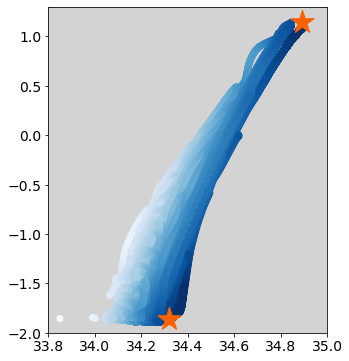

In [281]:
color_map = plt.cm.get_cmap('Blues')
reversed_color_map = color_map.reversed()

plt.figure(figsize=(17,6))
plt.rcParams['axes.facecolor']='lightgrey'
plt.subplot(131)
plt.scatter(meltwater14array['SA'],meltwater14array['CT'],c = meltwater14array['Meltwater_frac'],cmap=reversed_color_map, vmin=0,vmax=20)
plt.scatter(sa_mCDW, ct_mCDW, marker='*', s =600, c= '#FE6100',zorder=3)
plt.scatter(sa_WW, ct_WW, marker='*', s =600, c= '#FE6100',zorder=3)

plt.xlim(33.8,35);plt.ylim(-2,1.3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

### 8. Save meltwater14array dataframe as pickle file for later (Fig. 6) and repeat for other 2 years

In [282]:
# Doing this so it is easier for the user (comment out after run)
meltwater14array.to_pickle('meltwater14array_file')

## 2019

### 1. Read seal data

In [283]:
# To read from pickle after already created 
seal19 = pd.read_pickle('seal19_file')

### 2. Prepare data for plotting in TS space and combine all winter months in dataframe
Partitioning by month is not necessary, if not interested in monthly variability

In [284]:
# Bounds within study area (orange dashed box in Fig. 1)
# may 2019
may19TS = seal19[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100')
may19TS = may19TS[(may19TS['Datetime']>='2019-5-1') & (may19TS['Datetime']<'2019-6-1')]  # now constraining dates
may19TS = may19TS.reset_index()

# june 2019
june19TS = seal19[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100')
june19TS = june19TS[(june19TS['Datetime']>='2019-6-1') & (june19TS['Datetime']<'2019-7-1')]  # now constraining dates
june19TS = june19TS.reset_index()

# july 2019
july19TS = seal19[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100')
july19TS = july19TS[(july19TS['Datetime']>='2019-7-1') & (july19TS['Datetime']<'2019-8-1')]  # now constraining dates
july19TS = july19TS.reset_index()

# aug 2019
aug19TS = seal19[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100')
aug19TS = aug19TS[(aug19TS['Datetime']>='2019-8-1') & (aug19TS['Datetime']<'2019-9-1')]  # now constraining dates
aug19TS = aug19TS.reset_index()

TS2019 = pd.concat([may19TS,june19TS,july19TS,aug19TS])

### 3. Calculate mCDW and WW endoints (MW are from literature)

#### A. Winter Water
Winter Water is a freezing point (CT = 1.86 C). To find corresponding SA endpoint: extract maximum SA that lies on freezing line.

In [285]:
# Winter Water

# We are looking for maximum SA that lines on the freezing line (i.e., at CT -1.86)
TS2019_freezingline = TS2019[(TS2019['CT']<-1.85999) & (TS2019['CT']>-1.861)]
TS2019_freezingline.head()

TS2019_freezingline['SA'].max()

34.20510552122119

#### B. mCDW
To find mCDW SA and CT endpoints, do some simple stats to find the maximum and most commonly recurring measurements (mode) in a typical range for CDW (e.g., SA > 34.7, CT > 0.5)

Max: 34.9070604330642 Mode: 34.80353135736392


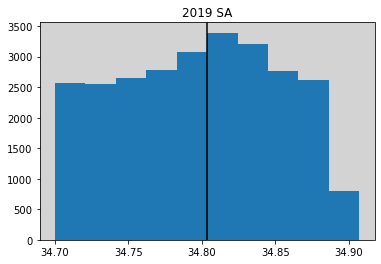

In [286]:
# 2019 SA
# plotting histograms for visualization

SA19_histcdw = TS2019[TS2019['SA']>34.7]

n, bins, _ = plt.hist(SA19_histcdw['SA']) 
mode_index = n.argmax()
mode14sa = bins[mode_index]

print('Max:',SA19_histcdw['SA'].max(),'Mode:',bins[mode_index])
plt.axvline(bins[mode_index], c='k')
plt.title('2019 SA')
plt.show()

Max: 0.9864610356010646 Mode: 0.7918915834401152


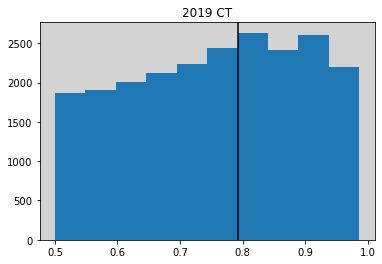

In [287]:
# 2019 CT
CT19_histcdw = TS2019[TS2019['CT']>0.5]

n, bins, _ = plt.hist(CT19_histcdw['CT']) 
mode_index = n.argmax()
mode14ct = bins[mode_index]

print('Max:',CT19_histcdw['CT'].max(),'Mode:',bins[mode_index])
plt.axvline(bins[mode_index], c='k')
plt.title('2019 CT')
plt.show()

Based on these stats and previous papers (Zheng et al., 2021), we keep maximum CT and SA values as end points for mCDW. See manuscript for full explanation.

### 4. Define water mass (mCDW, WW, MW) endpoints (from step 3 calculations)

CT is conservative temperature,
SA is absolute salinity

In [288]:
# water mass endpoints (rounded to 2nd decimal)
ct_MW = -90.8; sa_MW = 0;          # MW = glacial meltwater -- these are from literature (and are the same for all years)
# 2019 (these are determined using max vals)
ct_mCDW19 =0.99; sa_mCDW19 =34.91; # CDW = Circumpolar Deep Water 
ct_WW19=-1.86; sa_WW19=34.21;      # WW = Winter Water

### 5. Calculate meltwater fraction

In [289]:
# remove NaN values
winter19CTSA = may19TS[['CT','SA','z','Datetime','LATITUDE','LONGITUDE','Station']].append([june19TS[['CT','SA','z','Datetime','LATITUDE','LONGITUDE','Station']],july19TS[['CT','SA','z','Datetime','LATITUDE','LONGITUDE','Station']],aug19TS[['CT','SA','z','Datetime','LATITUDE','LONGITUDE','Station']]])
winter19CTSA.dropna(axis=0, how = 'any', inplace = True) #need inplace = True to get rid of all nan

# now all nans removed?
winter19CTSA.isna().sum()

# calculate meltwater fraction
T = winter19CTSA['CT']
S = winter19CTSA['SA']

Meltwater_Fraction19 = ((T-ct_mCDW19) - (S-sa_mCDW19)*(ct_WW19-ct_mCDW19)/(sa_WW19-sa_mCDW19))/((ct_MW-ct_mCDW19)-(sa_MW-sa_mCDW19)*(ct_WW19-ct_mCDW19)/(sa_WW19-sa_mCDW19))


### 6. Put output from 5 into dataframe to clean up code

In [290]:
# reset index arrays before append
# Meltwater
Meltwater_Fraction19 = pd.DataFrame(Meltwater_Fraction19)
Meltwater_Fraction19.columns =['Meltwater_frac']

Meltwater_Fraction19.reset_index(drop=True,inplace=True) # try reset index

# CTSA
winter19CTSA_reset = winter19CTSA.reset_index(drop=True)

meltwater19array = winter19CTSA_reset.merge(Meltwater_Fraction19*1000, how='outer', left_index=True, right_index=True)
# multiply by 1000 to get meltwater frac in g/kg instead of kg/kg to avoid really small values

### 7. Plot results

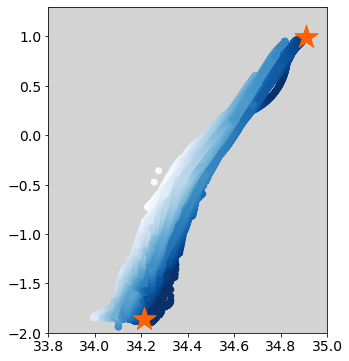

In [291]:
color_map = plt.cm.get_cmap('Blues')
reversed_color_map = color_map.reversed()

plt.figure(figsize=(17,6))
plt.rcParams['axes.facecolor']='lightgrey'
plt.subplot(131)
plt.scatter(meltwater19array['SA'],meltwater19array['CT'],c = meltwater19array['Meltwater_frac'],cmap=reversed_color_map, vmin=0,vmax=20)
plt.scatter(sa_mCDW19, ct_mCDW19, marker='*', s =600, c= '#FE6100',zorder=3)
plt.scatter(sa_WW19, ct_WW19, marker='*', s =600, c= '#FE6100',zorder=3)

plt.xlim(33.8,35);plt.ylim(-2,1.3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

### 8. Save meltwater14array dataframe as pickle file for later (Fig. 6) and repeat for other 2 years

In [292]:
# Doing this so it is easier for the user
meltwater19array.to_pickle('meltwater19array_file')

## 2020

### 1. Read seal data

In [293]:
# To read from pickle after already created 
#seal20 = pd.read_pickle('../AmundsenSeal2020_20220106.pkl')

seal20 = pd.read_pickle('seal20_file')

### 2. Prepare data for plotting in TS space and combine all winter months in dataframe
Partitioning by month is not necessary, if not interested in monthly variability

In [294]:
# Bounds within study area (orange dashed box in Fig. 1)
# may 2020
may20TS = seal20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100')
may20TS = may20TS[(may20TS['Datetime']>='2020-5-1') & (may20TS['Datetime']<'2020-6-1')]  # now constraining dates
may20TS = may20TS.reset_index()

# june 2020
june20TS = seal20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100')
june20TS = june20TS[(june20TS['Datetime']>='2020-6-1') & (june20TS['Datetime']<'2020-7-1')]  # now constraining dates
june20TS = june20TS.reset_index()

# july 2020
july20TS = seal20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100')
july20TS = july20TS[(july20TS['Datetime']>='2020-7-1') & (july20TS['Datetime']<'2020-8-1')]  # now constraining dates
july20TS = july20TS.reset_index()

# aug 2020
aug20TS = seal20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100')
aug20TS = aug20TS[(aug20TS['Datetime']>='2020-8-1') & (aug20TS['Datetime']<'2020-9-1')]  # now constraining dates
aug20TS = aug20TS.reset_index()

TS2020 = pd.concat([may20TS,june20TS,july20TS,aug20TS])

### 3. Calculate mCDW and WW endoints (MW are from literature)

#### A. Winter Water
Winter Water is a freezing point (CT = 1.86 C). To find corresponding SA endpoint: extract maximum SA that lies on freezing line.

In [295]:
# Winter Water

# We are looking for maximum SA that lines on the freezing line (i.e., at CT -1.86)
TS2020_freezingline = TS2020[(TS2020['CT']<-1.85999) & (TS2020['CT']>-1.861)]
TS2020_freezingline.head()

TS2020_freezingline['SA'].max()

# No data on freezing line in this year --> which is why we use 2019 WW values here (see manuscript for details)

nan

#### B. mCDW
To find mCDW SA and CT endpoints, do some simple stats to find the maximum and most commonly recurring measurements (mode) in a typical range for CDW (e.g., SA > 34.7, CT > 0.5)

Max: 34.91569732777902 Mode: 34.82942056290548


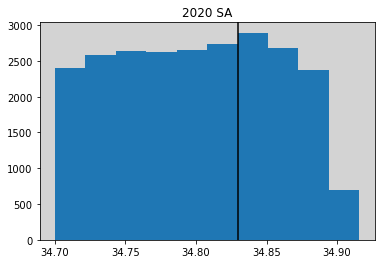

In [296]:
# 2020 SA
# plotting histograms for visualization

SA20_histcdw = TS2020[TS2020['SA']>34.7]

n, bins, _ = plt.hist(SA20_histcdw['SA']) 
mode_index = n.argmax()
mode14sa = bins[mode_index]

print('Max:',SA20_histcdw['SA'].max(),'Mode:',bins[mode_index])
plt.axvline(bins[mode_index], c='k')
plt.title('2020 SA')
plt.show()

Max: 1.0342171677077416 Mode: 0.9273758717110065


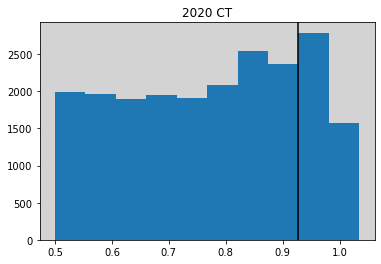

In [297]:
# 2020 CT
CT20_histcdw = TS2020[TS2020['CT']>0.5]

n, bins, _ = plt.hist(CT20_histcdw['CT']) 
mode_index = n.argmax()
mode14ct = bins[mode_index]

print('Max:',CT20_histcdw['CT'].max(),'Mode:',bins[mode_index])
plt.axvline(bins[mode_index], c='k')
plt.title('2020 CT')
plt.show()

Based on these stats and previous papers (Zheng et al., 2021), we keep maximum CT and SA values as end points for mCDW. See manuscript for full explanation.

### 4. Define water mass (mCDW, WW, MW) endpoints (from step 3 calculations)

CT is conservative temperature,
SA is absolute salinity

In [298]:
# water mass endpoints (rounded to 2nd decimal)
ct_MW = -90.8; sa_MW = 0;          # MW = glacial meltwater -- these are from literature (and are the same for all years)
# 2020
ct_mCDW20 =1.03; sa_mCDW20 =34.92;
ct_WW20=-1.86; sa_WW20=34.21 # no data at the freezling line in 2020, so used 2019 end points (see manuscript)

### 5. Calculate meltwater fraction

In [299]:
# remove NaN values
winter20CTSA = may20TS[['CT','SA','z','Datetime','LATITUDE','LONGITUDE','Station']].append([june20TS[['CT','SA','z','Datetime','LATITUDE','LONGITUDE','Station']],july20TS[['CT','SA','z','Datetime','LATITUDE','LONGITUDE','Station']],aug20TS[['CT','SA','z','Datetime','LATITUDE','LONGITUDE','Station']]])
winter20CTSA.dropna(axis=0, how = 'any', inplace = True) #need inplace = True to get rid of all nan

# now all nans removed?
winter20CTSA.isna().sum()

# calculate meltwater fraction
T = winter20CTSA['CT']
S = winter20CTSA['SA']

Meltwater_Fraction20 = ((T-ct_mCDW20) - (S-sa_mCDW20)*(ct_WW20-ct_mCDW20)/(sa_WW20-sa_mCDW20))/((ct_MW-ct_mCDW20)-(sa_MW-sa_mCDW20)*(ct_WW20-ct_mCDW20)/(sa_WW20-sa_mCDW20))


### 6. Put output from 5 into dataframe to clean up code

In [300]:
# reset index arrays before append
# Meltwater
Meltwater_Fraction20 = pd.DataFrame(Meltwater_Fraction20)
Meltwater_Fraction20.columns =['Meltwater_frac']

Meltwater_Fraction20.reset_index(drop=True,inplace=True) # try reset index

# CTSA
winter20CTSA_reset = winter20CTSA.reset_index(drop=True)

meltwater20array = winter20CTSA_reset.merge(Meltwater_Fraction20*1000, how='outer', left_index=True, right_index=True)
# multiply by 1000 to get meltwater frac in g/kg instead of kg/kg to avoid really small values

### 7. Plot results

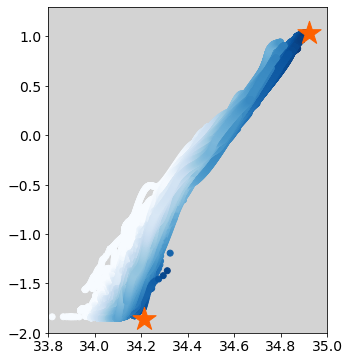

In [301]:
color_map = plt.cm.get_cmap('Blues')
reversed_color_map = color_map.reversed()

plt.figure(figsize=(17,6))
plt.rcParams['axes.facecolor']='lightgrey'
plt.subplot(131)
plt.scatter(meltwater20array['SA'],meltwater20array['CT'],c = meltwater20array['Meltwater_frac'],cmap=reversed_color_map, vmin=0,vmax=20)
plt.scatter(sa_mCDW20, ct_mCDW20, marker='*', s =600, c= '#FE6100',zorder=3)
plt.scatter(sa_WW20, ct_WW20, marker='*', s =600, c= '#FE6100',zorder=3)

plt.xlim(33.8,35);plt.ylim(-2,1.3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

### Plot together

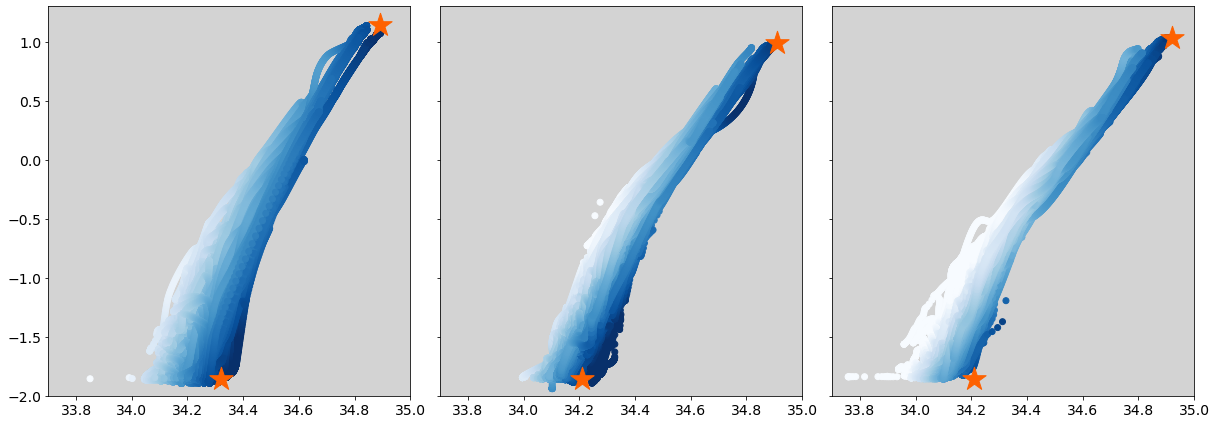

In [302]:
color_map = plt.cm.get_cmap('Blues')
reversed_color_map = color_map.reversed()

plt.figure(figsize=(17,6))
plt.rcParams['axes.facecolor']='lightgrey'
plt.subplot(131)
plt.scatter(meltwater14array['SA'],meltwater14array['CT'],c = meltwater14array['Meltwater_frac'],cmap=reversed_color_map, vmin=0,vmax=20)
plt.scatter(sa_mCDW, ct_mCDW, marker='*', s =600, c= '#FE6100',zorder=3)
plt.scatter(sa_WW, ct_WW, marker='*', s =600, c= '#FE6100',zorder=3)
plt.xlim(33.7,35);plt.ylim(-2,1.3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(132)
plt.scatter(meltwater19array['SA'],meltwater19array['CT'],c = meltwater19array['Meltwater_frac'],cmap=reversed_color_map,vmin=0,vmax=20)
#plt.title('2019')
plt.scatter(sa_mCDW19, ct_mCDW19, marker='*', s =600, c= '#FE6100',zorder=3)
plt.scatter(sa_WW19, ct_WW19, marker='*', s =600, c= '#FE6100',zorder=3)
plt.xlim(33.7,35);plt.ylim(-2,1.3)
plt.tick_params(labelleft=False)  
plt.xticks(fontsize=14)

plt.subplot(133)
plt.scatter(meltwater20array['SA'],meltwater20array['CT'],c = meltwater20array['Meltwater_frac'],cmap=reversed_color_map,vmin=0,vmax=20)
plt.scatter(sa_mCDW20, ct_mCDW20, marker='*', s =600, c= '#FE6100',zorder=3)
plt.scatter(sa_WW19, ct_WW19, marker='*', s =600, c= '#FE6100',zorder=3)
plt.xlim(33.7,35);plt.ylim(-2,1.3)
# cbar = plt.colorbar()
# cbar.set_label('Meltwater fraction [g/kg]')
plt.tick_params(labelleft=False)  
plt.xticks(fontsize=14)

plt.tight_layout()

plt.savefig('fig4_updated.png', format='png', dpi=400)

In [303]:
meltwater14array['Meltwater_frac'].mean(),meltwater19array['Meltwater_frac'].mean(),meltwater20array['Meltwater_frac'].mean()

(5.651187213626671, 7.059680379366323, 10.709813683489244)

### 8. Save meltwater14array dataframe as pickle file for later (Fig. 6) and repeat for other 2 years

In [304]:
# Doing this so it is easier for the user
meltwater20array.to_pickle('meltwater20array_file')

### 9. I save all panels and format for submission in illustrator or powerpoint :)

Screenshot of Fig. 4 from Savidge et al., 2023:

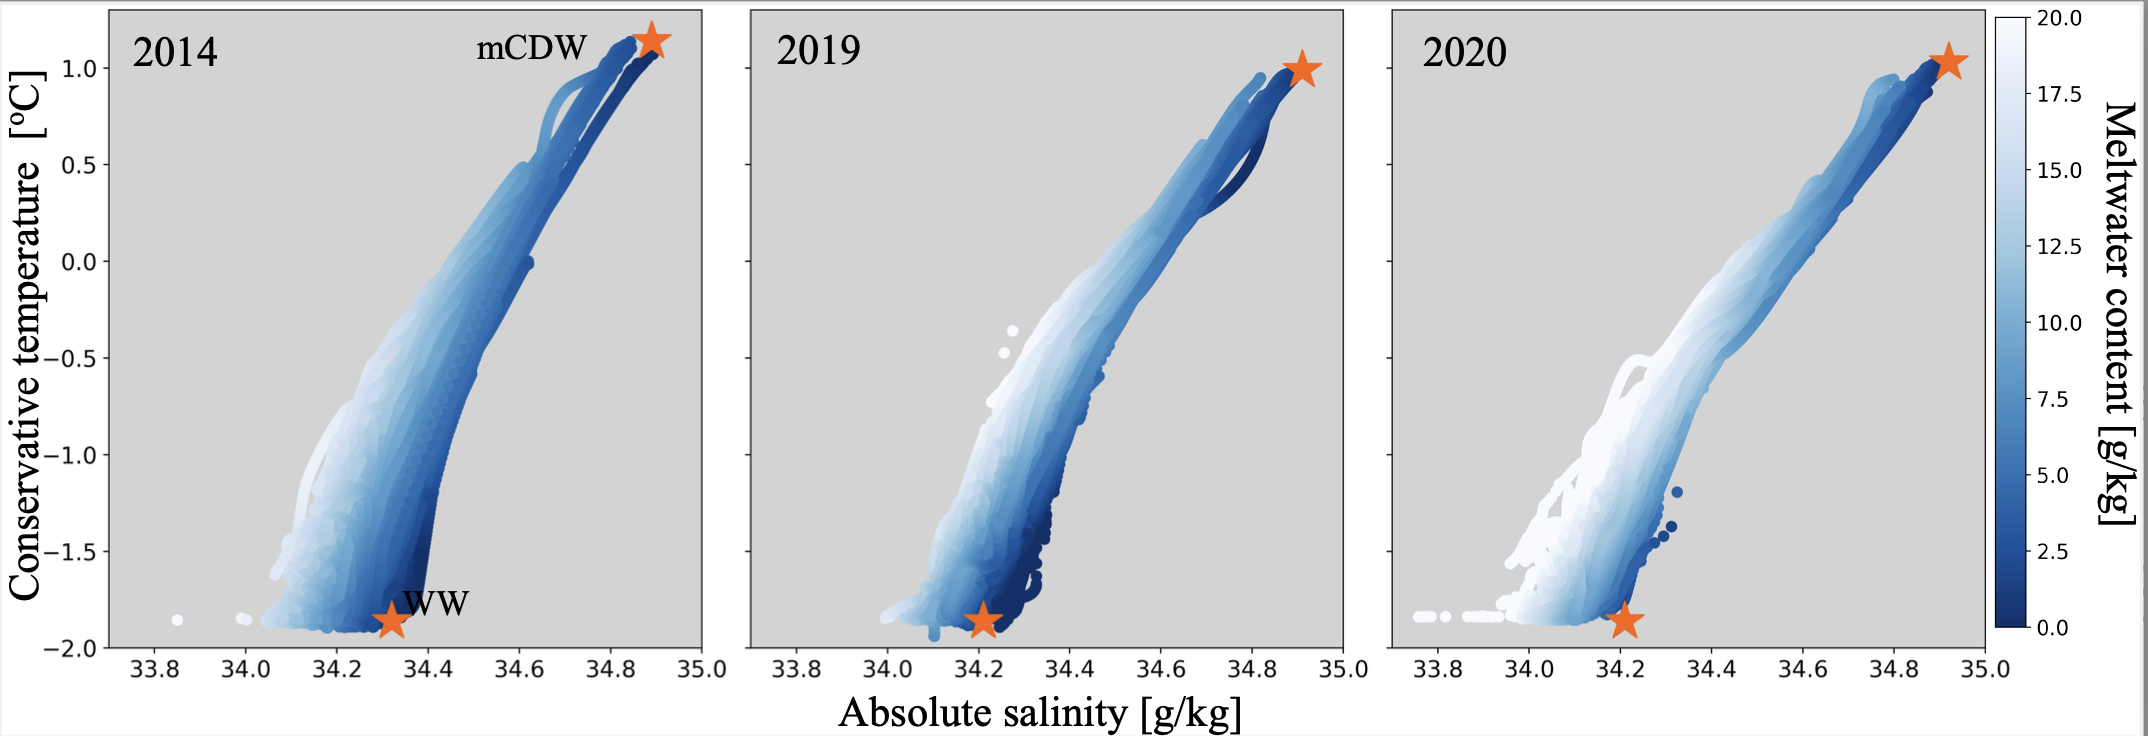

### ~ES